2023-12-10 23:22:37.996487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 23:22:37.996549: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 23:22:37.996582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 23:22:38.003930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 23:22:39.228903: W tensorflow/compiler/

Loaded model from disk
Found 416 files belonging to 2 classes.


2023-12-10 23:22:41.813675: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-10 23:22:44.919036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8801
2023-12-10 23:22:45.663101: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


{'loss': 0.4941902756690979, 'accuracy': 0.8269230723381042, 'true_positives': 196.0, 'true_negatives': 148.0, 'false_positives': 60.0, 'false_negatives': 12.0, 'recall': 0.942307710647583, 'precision': 0.765625}


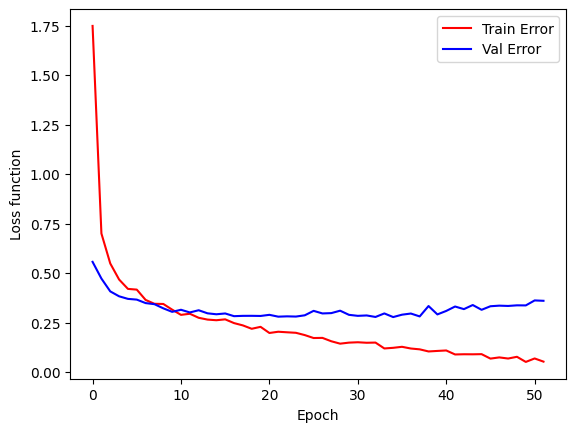

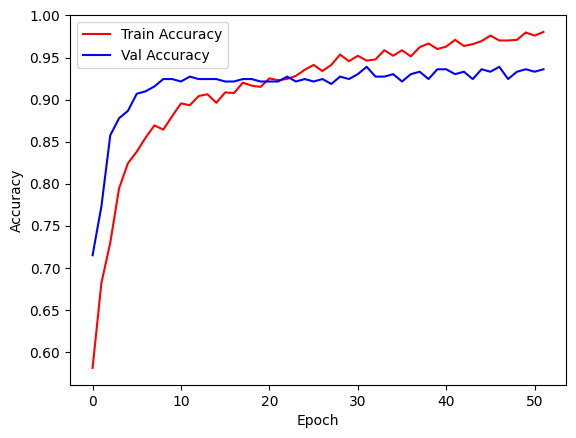

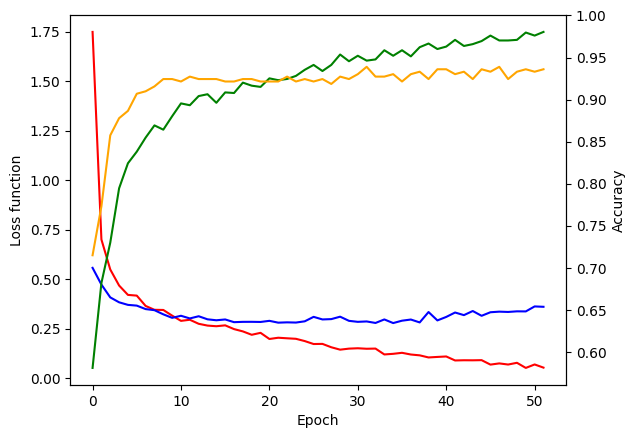

In [1]:
from tensorflow.keras.models import load_model,model_from_json
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

physical_devices=tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
SEED = 7
tf.keras.utils.set_random_seed(SEED) #Establece la semilla de Python, Numpy y TensorFlow. Para que los números aleatorios sean los mismos cada vez que se corre
tf.config.experimental.enable_op_determinism() #Para que con los mismos inputs, se tengan los mismos outputs cada vez que se corre

config = "224_4_1e-06"

json_file = open('training_files/model_{}.json'.format(config), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("training_files/model_{}.h5".format(config))
print("Loaded model from disk")

model=loaded_model

image_size = (224,224)
batch_size = 4
initial_learning_rate=1e-6

model.compile(
    optimizer=keras.optimizers.Adam(initial_learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy","TruePositives","TrueNegatives","FalsePositives", "FalseNegatives","Recall","Precision"]
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "../../datasets/test_SSRT/",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
print(model.evaluate(x=test_ds,verbose=0,return_dict=True))

df=pd.read_csv("training_files/history_{}.csv".format(config))
df=df.rename(columns={"Unnamed: 0":"epoch"})

def plot_loss_function():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss function')
    plt.plot(df['epoch'], df['loss'],'r', label='Train Error')
    plt.plot(df['epoch'], df['val_loss'],'b', label = 'Val Error')
    plt.legend()

plot_loss_function()

def plot_accuracy():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(df['epoch'], df['accuracy'],'r', label='Train Accuracy')
    plt.plot(df['epoch'], df['val_accuracy'],'b', label = 'Val Accuracy')
    plt.legend()

plot_accuracy()

def plot_both_validation():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss function')
    plt.plot(df['epoch'], df['loss'],'r', label='Train Error')
    plt.plot(df['epoch'], df['val_loss'],'b', label='Val Error')
    #plt.plot(hist.epoch, hist.history['accuracy'],'g', label='Train Accuracy')
    #plt.plot(hist.epoch, hist.history['val_accuracy'],'orange', label='Val Accuracy')
    #plt.plot(hist.epoch, hist.history['val_accuracy'],'g', label = 'Val Accuracy')
    
    #plt.legend()
    ax2 = plt.twinx()
    ax2.set_ylabel('Accuracy')
    ax2.plot(df['epoch'], df['accuracy'],'g', label = 'Train Accuracy')
    ax2.plot(df['epoch'], df['val_accuracy'],'orange', label = 'Val Accuracy')
    
plot_both_validation()

In [2]:
acc=model.evaluate(x=test_ds,verbose=0,return_dict=True)['accuracy']
tp=model.evaluate(x=test_ds,verbose=0,return_dict=True)['true_positives']
tn=model.evaluate(x=test_ds,verbose=0,return_dict=True)['true_negatives']
fp=model.evaluate(x=test_ds,verbose=0,return_dict=True)['false_positives']
fn=model.evaluate(x=test_ds,verbose=0,return_dict=True)['false_negatives']
r=model.evaluate(x=test_ds,verbose=0,return_dict=True)['recall']
p=model.evaluate(x=test_ds,verbose=0,return_dict=True)['precision']
f1 = 2*(r*p)/(r+p)
fnr = fn/(tp+fn)
fpr = fp/(fp+tn)
print("El accuracy es de: {} %".format(round(acc*100,2)))
print("El TP es de: {}".format(tp))
print("El TN es de: {}".format(tn))
print("El FP es de: {}".format(fp))
print("El FN es de: {}".format(fn))
print("El Recall es de: {} %".format(round(r*100,2)))
print("La precisión es de: {} %".format(round(p*100,2)))
print("El F1 Score es de: {} %".format(round(f1*100,2)))
print("El FNR es: {} %".format(round(fnr*100,2)))
print("El FPR es de: {} %".format(round(fpr*100,2)))

El accuracy es de: 82.69 %
El TP es de: 196.0
El TN es de: 148.0
El FP es de: 60.0
El FN es de: 12.0
El Recall es de: 94.23 %
La precisión es de: 76.56 %
El F1 Score es de: 84.48 %
El FNR es: 5.77 %
El FPR es de: 28.85 %


In [3]:
train_loss = df['loss'][len(df)-1]
val_loss = df['val_loss'][len(df)-1]
val_acc = round(df['val_accuracy'][len(df)-1]*100,2)
train_acc = round(df['accuracy'][len(df)-1]*100,2)
print("El train accuracy es de: {} %".format(train_acc))
print("El train loss es de: {}".format(train_loss))
print("El val accuracy es de: {} %".format(val_acc))
print("El val loss es de: {}".format(val_loss))

El train accuracy es de: 98.04 %
El train loss es de: 0.0529738813638687
El val accuracy es de: 93.6 %
El val loss es de: 0.360075831413269


In [4]:
######################################## Get classification time ########################################

In [5]:
#class_time = []

In [ ]:
from tensorflow.keras.models import load_model,model_from_json
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from datetime import timedelta

physical_devices=tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
SEED = 7
tf.keras.utils.set_random_seed(SEED) #Establece la semilla de Python, Numpy y TensorFlow. Para que los números aleatorios sean los mismos cada vez que se corre
tf.config.experimental.enable_op_determinism() #Para que con los mismos inputs, se tengan los mismos outputs cada vez que se corre

config = "512_16_1e-07"

image_size = (512,512)
initial_learning_rate=1e-7

json_file = open('training_files/model_{}.json'.format(config), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("training_files/model_{}.h5".format(config))
print("Loaded model from disk")

model=loaded_model

model.compile(
    optimizer=keras.optimizers.Adam(initial_learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy","TruePositives","TrueNegatives","FalsePositives", "FalseNegatives","Recall","Precision"]
)



'from tensorflow.keras.models import load_model,model_from_json\nimport tensorflow as tf\nfrom tensorflow import keras\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport os\nimport time\nfrom datetime import timedelta\n\nphysical_devices=tf.config.list_physical_devices(\'GPU\')\ntf.config.experimental.set_memory_growth(physical_devices[0], True)\nSEED = 7\ntf.keras.utils.set_random_seed(SEED) #Establece la semilla de Python, Numpy y TensorFlow. Para que los números aleatorios sean los mismos cada vez que se corre\ntf.config.experimental.enable_op_determinism() #Para que con los mismos inputs, se tengan los mismos outputs cada vez que se corre\n\nconfig = "512_16_1e-07"\n\nimage_size = (512,512)\ninitial_learning_rate=1e-7\n\njson_file = open(\'training_files/model_{}.json\'.format(config), \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n\n# load weights into new model\nloaded_model.load_weights("training_fil

In [ ]:
# SRB
cont = 1
time_sum = 0
for line in os.listdir("../../datasets/dataset_5/test/srb"):
    if line[-3:]=="png" and cont <= 10:
        img = keras.utils.load_img(
            "../../datasets/dataset_5/test/srb/"+line, target_size=image_size
        )
        img_array = keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis
        
        #start_time = time.monotonic()
        start_time = time.time()
          
        predictions = model.predict(img_array)
        #end_time = time.monotonic()
        end_time = time.time()
        t = end_time - start_time
        print(timedelta(seconds=t))
        
        score = float(predictions[0])
        print(score)

        time_sum += t
        cont += 1
    else:
        break

'cont = 1\ntime_sum = 0\nfor line in os.listdir("../../datasets/dataset_5/test/srb"):\n    if line[-3:]=="png" and cont <= 10:\n        img = keras.utils.load_img(\n            "../../datasets/dataset_5/test/srb/"+line, target_size=image_size\n        )\n        img_array = keras.utils.img_to_array(img)\n        img_array = tf.expand_dims(img_array, 0)  # Create batch axis\n        \n        #start_time = time.monotonic()\n        start_time = time.time()\n          \n        predictions = model.predict(img_array)\n        #end_time = time.monotonic()\n        end_time = time.time()\n        t = end_time - start_time\n        print(timedelta(seconds=t))\n        \n        score = float(predictions[0])\n        print(score)\n\n        time_sum += t\n        cont += 1\n    else:\n        break'